In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from icecream import ic

from scipy.optimize import curve_fit

plt.rc('text', usetex=True)
plt.rc('font', family='STIXGeneral')

## Time delay spectral fit with SciPy, time resolution and FWHM (full width at half maximum)

ic| mean: 1018.4141294708838, sigma: 100.37922301957995
ic| y_half: 13.73621931362704
ic| x_asc: 905.6000302933694
ic| gaussian(x_asc, *popt): 13.736155082614513
ic| x_desc: 1135.4942128504938
ic| gaussian(x_desc, *popt): 13.736100463378142
ic| fwhm: 229.8941825571244
ic| popt: array([  27.47273444, 1020.54695672,   97.62584292])
ic| error: array([0.0890469 , 0.36540071, 0.36540071])


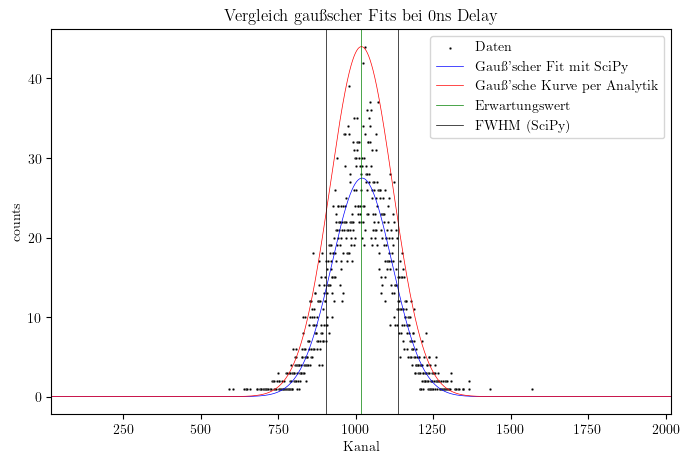

ic| mean: 1691.200889248181, sigma: 100.74068088404637
ic| y_half: 10.034728919245069
ic| x_asc: 1577.781223836034
ic| gaussian(x_asc, *popt): 10.034727525639738
ic| x_desc: 1808.8135634861512
ic| gaussian(x_desc, *popt): 10.034710885204891
ic| fwhm: 231.03233965011714
ic| popt: array([  20.06955   , 1693.29732457,   98.11000783])
ic| error: array([0.0699693 , 0.39496116, 0.39496116])


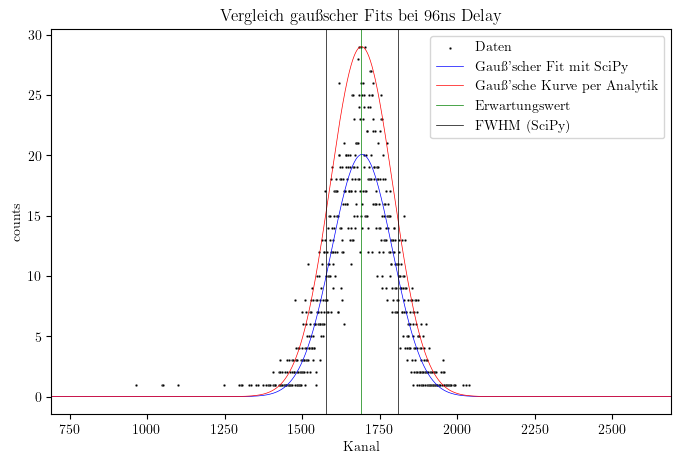

ic| peakdifference: 672.7867597772972


FWHM of 0ns and 96ns:   [229.8941825571244, 231.03233965011714]


In [18]:
def gaussian(x,y,mean,sigma): 
    return y * np.exp(-(x-mean)**2 / (2*sigma**2) )

peak=[]
std=[]
fwhmlist=[]
x_list=[]
def timedelayplot(data, title):
    # this function is actually not good, as it computes the mean, computes the gaussian and plots the function all in one. This reduces flexibility. 
    df = pd.read_csv(data)
    df.columns = ['counts']
    df.index.name = 'Kanal'

    # computing gaussian parameters mu and sigma, required for both analytical and numerical fit
    y = df['counts']
    x = df.index
    mean = sum(y * x) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y) )
    ic(mean, sigma)
    peak.append(mean)
    std.append(sigma)

    # performing a gaussian fit
    popt,pcov = curve_fit(gaussian,x,y,p0=[max(y),mean,sigma])

    # fwhm
    t_asc = np.linspace(0,mean,1000)
    t_desc = np.linspace(mean,2400,1000)
    y_half = gaussian(x,*popt).max() / 2
    ic(y_half)
    x_asc = np.interp(y_half, gaussian(t_asc,*popt), t_asc)
    ic(x_asc)
    ic(gaussian(x_asc, *popt))
    x_desc = np.interp(y_half, gaussian(t_desc,*popt)[::-1], t_desc[::-1])
    ic(x_desc)
    ic(gaussian(x_desc, *popt))
    fwhm = x_desc - x_asc
    ic(fwhm)
    fwhmlist.append(fwhm)
    x_list.append(x_asc)
    x_list.append(x_desc)

    # error 
    ic(popt)
    error = np.sqrt(np.diag(pcov))
    ic(error)
    
    # plot
    fig, ax = plt.subplots(figsize=(8,5))
    df['counts'] = df.loc[df['counts'] > 0]
    sns.scatterplot(x=df.index, y=df['counts'], s=3, color='k', label='Daten')
    ax.plot(x, gaussian(x,*popt), 'b-', linewidth=.5, label=f'Gauß\'scher Fit mit SciPy')
    ax.plot(x, gaussian(x,y=df['counts'].max(),mean=mean,sigma=sigma), color='r', linewidth=.5, label='Gauß\'sche Kurve per Analytik')
    ax.axvline(mean, linewidth=.5, color='g', label='Erwartungswert')
    ax.axvline(x_asc, linewidth=.5, color='k', label='FWHM (SciPy)')
    ax.axvline(x_desc, linewidth=.5, color='k')
    ax.set_title(title)
    ax.set_xlim(mean-1000, mean+1000) 
    ax.legend()
    plt.savefig(f"plots/{title}.pdf")
    plt.show()


timedelayplot('Results/zeitspektrum_0nsdelay.asc','Vergleich gaußscher Fits bei 0ns Delay')
timedelayplot('Results/zeitspektrum_96nsdelay.asc','Vergleich gaußscher Fits bei 96ns Delay')

peakdifference = peak[1]-peak[0]
ic(peakdifference)
# print()

print("FWHM of 0ns and 96ns:  ", fwhmlist)

- The manual curve (red) includes the maximal peak value $\textbf{at the cost of overestimating the overall count rate}$. Notice how most data points are under the curve.
- The fitted curve (blue) takes the variation of the count rate into account. Notice how the curve goes through the middle of the "width" of the data. It doesn't reach the maximal count value, but this is due to the large variation of count value at the mean channel value. \
Conclusion: the fitted plot is the more reliable one. 

\begin{align}
    \Delta_{\text{difference}} t &= b \cdot \Delta_{\text{difference}} K
\end{align}
And we use the standard deviation as an initial point for the error propagation:
\begin{align}
    \Delta b &= \frac{\Delta t}{(\Delta K)^2} \Delta(\Delta K) \\
    \Delta (\Delta K) &= \sqrt{ \sigma_1^2 + \sigma_2^2 } \\
    \Delta T &= \sqrt{ (K_i*\Delta b)^2 + (b * \sigma_i) }
\end{align}

ic| b: 0.14269008508992875
ic| delta_K: 142.21347755749395
ic| delta_b: 0.030161790372228194
ic| [b,delta_b]: [0.14269008508992875, 0.030161790372228194]
ic| std: [100.37922301957995, 100.74068088404637]
ic| [t0, delta_t0]: [0, 14.3231198739248]
ic| [t96, delta_t96]: [13.69824816863316, 14.663423861679231]
ic| x_list: [905.6000302933694, 1135.4942128504938, 1577.781223836034, 1808.8135634861512]
ic| fwhmlist: [229.8941825571244, 231.03233965011714]
ic| [delta_fwhm0, delta_fwhm96]: [6.934020142082745, 6.968348997732257]


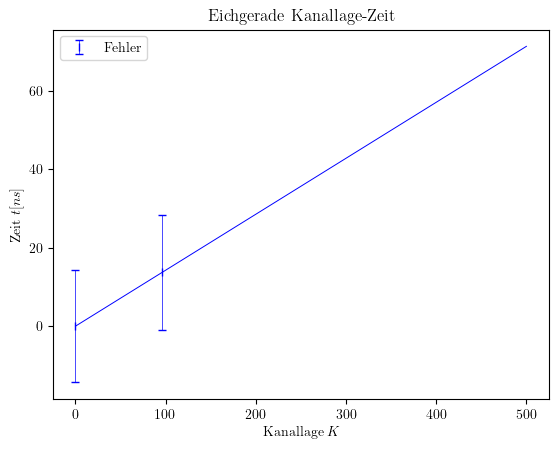

In [21]:
b = 96 / peakdifference
ic(b)
delta_K = np.sqrt( std[0]**2 + std[1]**2 )
ic(delta_K)
delta_b = (96 * delta_K) / (peakdifference)**2
ic(delta_b)
ic([b,delta_b])
ic(std)

t0 = 0
delta_t0 = b * std[0]
ic([t0, delta_t0])
t96 = b * 96
delta_t96 = np.sqrt( (96 * delta_b)**2 + (b * std[1])**2 )
ic([t96, delta_t96])

x_error_points = [0, 96]
y_error_points = [0, t96]
y_errors = [delta_t0, delta_t96]

ic(x_list)
delta_fwhm0 = np.sqrt( (x_list[1] - x_list[0])**2 * delta_b**2  )
delta_fwhm96 = np.sqrt( (x_list[3] - x_list[2])**2 * delta_b**2  )
ic(fwhmlist)
ic([delta_fwhm0, delta_fwhm96])

def calibratetime(ch):
    return np.float64(ch) * np.float64(b)

ch = np.linspace(0,500,1000)
fig, ax = plt.subplots()
ax.plot(ch, calibratetime(ch), 'b', linewidth=.7)
ax.errorbar(x_error_points, y_error_points, yerr=y_errors, fmt='|', capsize=3, color='b',linewidth=.5, label='Fehler')
ax.set_title('Eichgerade Kanallage-Zeit')
ax.set(xlabel=f'Kanallage $K$', ylabel=f'Zeit $t [ns]$ ')
ax.legend()
plt.savefig("plots/Eichgerade Zeit.pdf")
plt.show()

In [22]:
calibratedfwhm = []
ic(fwhmlist)
for k in fwhmlist:
    calibratedfwhm.append(calibratetime(k))

ic(calibratedfwhm)
ic([delta_fwhm0, delta_fwhm96])
print("FWHM (calibrated, in unit ns):   ", calibratedfwhm)

ic| fwhmlist: [229.8941825571244, 231.03233965011714]
ic| calibratedfwhm: [32.803620470755696, 32.96602420320053]
ic| [delta_fwhm0, delta_fwhm96]: [6.934020142082745, 6.968348997732257]


FWHM (calibrated, in unit ns):    [32.803620470755696, 32.96602420320053]
